# タイタニックの生存予測

kaggle の入門として使われている[タイタニックの生存データ](https://www.kaggle.com/c/titanic)をもとに EDA, モデル作成・評価を行う。

![kaggle](https://storage.googleapis.com/kaggle-media/welcome/screen1.png)

タイタニックのカラムの意味は以下。

- pclass： 旅客クラス（等級）
- name： 乗客の名前
- sex： 性別
    - male: 男性
    - female: 女性
- age： 年齢
- sibsp： タイタニック号に同乗している兄弟や配偶者の数
- parch： タイタニック号に同乗している親や子供の数
- ticket： チケット番号
- fare： 旅客運賃
- cabin： 客室番号
- embarked： 出港地
    - C: Cherbourg：シェルブール
    - Q: Queenstown：クイーンズタウン
    - S: Southampton：サウサンプトン
- boat： 救命ボート番号
- body： 遺体収容時の識別番号
- home.dest： 自宅または目的地
- survived：生存状況
    - 0: 死亡
    - 1: 生存


## 1. 準備
### 1.1. パッケージの読み込み

In [1]:
!pip install seaborn

     |████████████████████████████████| 286kB 9.6MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from abeja.datalake import Client as DatalakeClient
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("darkgrid")

### 1.2. データの読み込み

In [3]:
DATALAKE_CHANNEL_ID = 'xxxxxx'
TRAIN_DATALAKE_FILE_ID = 'xxxxx'
TEST_DATALAKE_FILE_ID = 'xxxxx'

In [4]:
datalake_client = DatalakeClient()
channel = datalake_client.get_channel(DATALAKE_CHANNEL_ID)
train_file = channel.get_file(TRAIN_DATALAKE_FILE_ID)
test_file = channel.get_file(TEST_DATALAKE_FILE_ID)

In [5]:
df_train = pd.read_csv(train_file.download_uri)
df_test = pd.read_csv(test_file.download_uri)
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


各種情報を表示

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
df_train.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Boulos, Miss. Nourelain",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


NA データのカウント

In [8]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## 2. [EDA](https://www.kaggle.com/dejavu23/titanic-eda-to-ml-beginner)
### 2.1. pair plot

各変数の関係性を把握するために pair plot で可視化する。

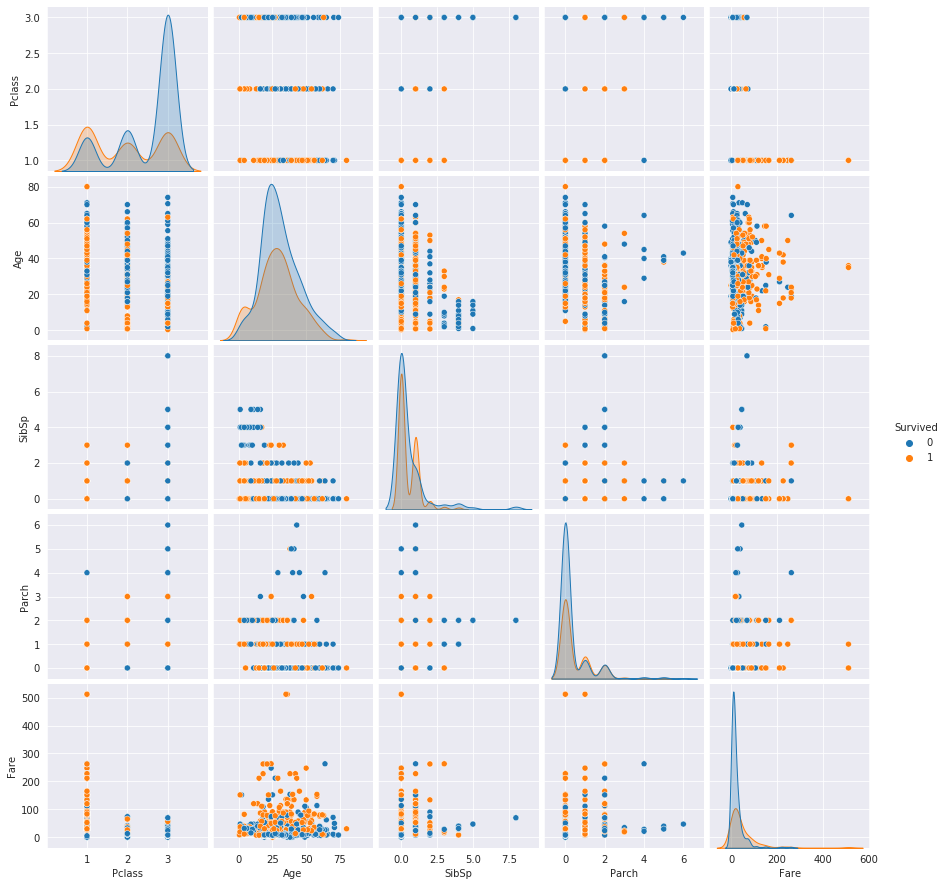

In [9]:
pp = sns.pairplot(df_train[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]], 
                  hue="Survived")

### 2.2. 生存率の確認

ベースとなる全体の生存率を可視化・計算する。

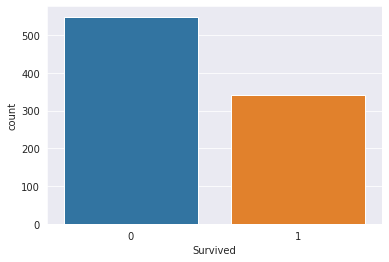

In [10]:
sns.countplot(x='Survived', data=df_train)

In [11]:
print(df_train.Survived.sum()/df_train.Survived.count())

0.3838383838383838


### 2.3. 性別による生存率の確認

性別によって生存率が異なるかを確認する。

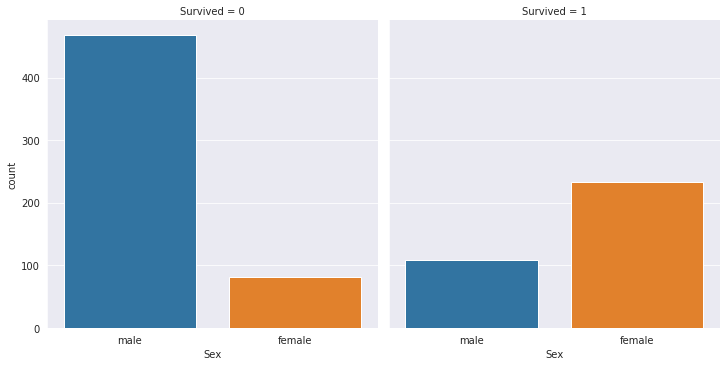

In [12]:
sns.catplot(x='Sex', col='Survived', kind='count', data=df_train)

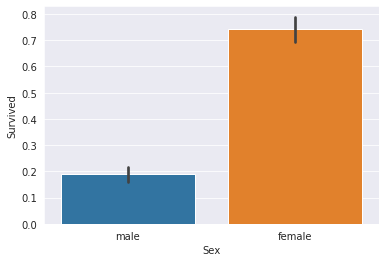

In [13]:
sns.barplot(x='Sex', y='Survived', data=df_train)

女性の方が生存する確率が異なることが分かった。
実際に数値にすると以下。

In [14]:
print("% of women survived: " , df_train[df_train.Sex == 'female'].Survived.sum()/df_train[df_train.Sex == 'female'].Survived.count())
print("% of men survived:   " , df_train[df_train.Sex == 'male'].Survived.sum()/df_train[df_train.Sex == 'male'].Survived.count())

% of women survived:  0.7420382165605095
% of men survived:    0.18890814558058924


### 2.4. Pclass による生存率

Pclass（旅客クラスの等級）による生存率の差をみる。

In [15]:
pd.crosstab(df_train.Pclass, df_train.Survived, margins=True).style.background_gradient(cmap='autumn_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


In [16]:
print("Pclass=1 : ", df_train.Survived[df_train.Pclass == 1].sum()/df_train[df_train.Pclass == 1].Survived.count())
print("Pclass=2 : ", df_train.Survived[df_train.Pclass == 2].sum()/df_train[df_train.Pclass == 2].Survived.count())
print("Pclass=3 : ", df_train.Survived[df_train.Pclass == 3].sum()/df_train[df_train.Pclass == 3].Survived.count())

Pclass=1 :  0.6296296296296297
Pclass=2 :  0.47282608695652173
Pclass=3 :  0.24236252545824846


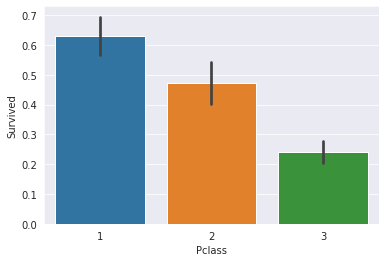

In [17]:
sns.barplot(x='Pclass', y='Survived', data=df_train);

Pclass の等級が小さいほど生存率が高くなっている。

### 2.5. 性別と Pclass の組み合わせによる生存率

次に性別と Pclass の組合わせで生存率を確認する。

In [18]:
pd.crosstab([df_train.Sex, df_train.Survived], df_train.Pclass, margins=True).style.background_gradient(cmap='autumn_r')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


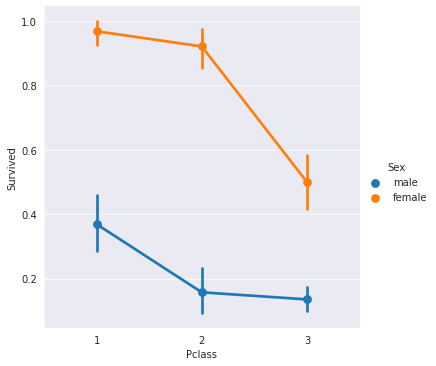

In [19]:
sns.catplot('Pclass','Survived',hue='Sex', kind='point', data=df_train);

男性の生存率が低く、女性の生存率が高いこと、等級が少ないほうが生存率が高いという傾向は同じである。
一方で

- 男性の生存率はPclass1とPclass2の間に大きな差があり、Pclass2とPclass3の間の差は小さい
- 女性の生存率はPclass2とPclass3の間に大きな差があり、Pclass1とPclass2の間の差は小さい

という違いが見られた

### 2.6. Embarked による生存率

出港地による生存率の差を確認する。
ちなみに

- S: Cherbourg（シェルブール）
- Q: Queenstown（クイーンズタウン）
- S: Southanmpton（サウサンプトン）

となっている。

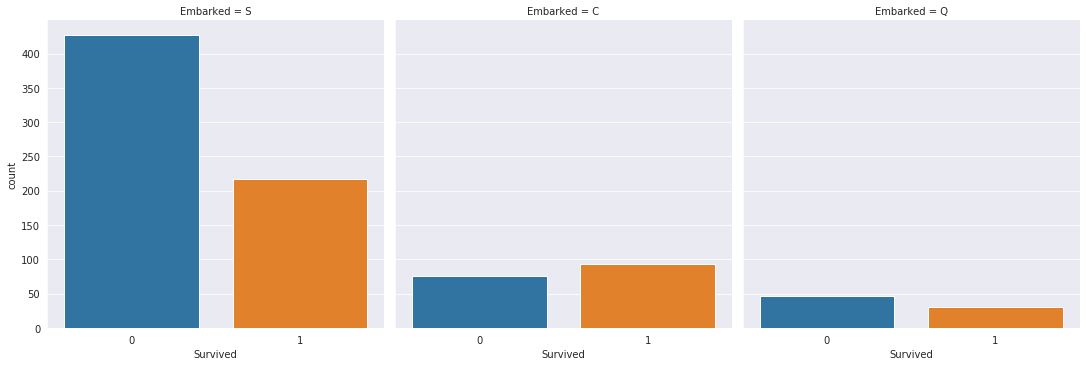

In [20]:
sns.catplot(x='Survived', col='Embarked', kind='count', data=df_train);

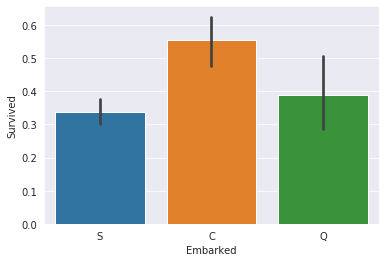

In [21]:
sns.barplot(x='Embarked', y='Survived', data=df_train);

C（シェルブールで乗った人の生存率が高くなっている）

### 2.7. Embark と性別の組み合わせによる生存率

シェルブールで乗った人の生存率が高いのはシェルブールで乗った人の多くが女性という可能性があるので、性別でも見てみる。

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


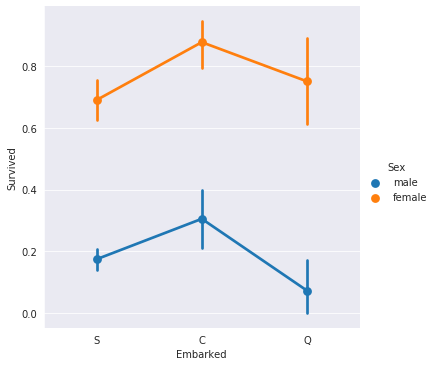

In [22]:
sns.catplot('Embarked','Survived', hue= 'Sex', kind='point', data=df_train);

男女ともにシェルブールで乗った人の生存率は高いことが分かった。

### 2.8. 年齢による生存率

年齢の生存率への影響についてみる。  
まずは年齢を5つに区切る（瓶詰め）

In [23]:
for df in [df_train, df_test]:
    df['Age_bin']=np.nan
    for i in range(5,0,-1):
        df.loc[ df['Age'] <= i*10, 'Age_bin'] = i

In [24]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_bin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,4.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,3.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,2.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,NaN
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,3.0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


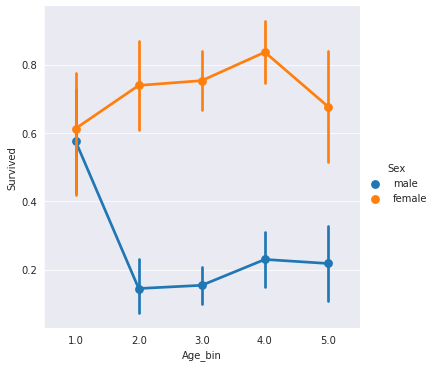

In [25]:
sns.catplot('Age_bin','Survived',hue='Sex',kind='point',data=df_train);

男女ともに2以降の区分で、年齢が上がるとともに生存率が高くなっている。
男性の1が生存率が異常に高くなっているが、これは子供と認識されて生存率が高くなっていると考えられる。

### 2.9. Fare_bin と生存率

Fare（旅客運賃）を瓶詰めして、それと生存率の関係を見る。  
まずは Fare を瓶詰めする。

In [26]:
for df in [df_train, df_test]:
    df['Fare_bin']=np.nan
    for i in range(12,0,-1):
        df.loc[ df['Fare'] <= i*50, 'Fare_bin'] = i

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


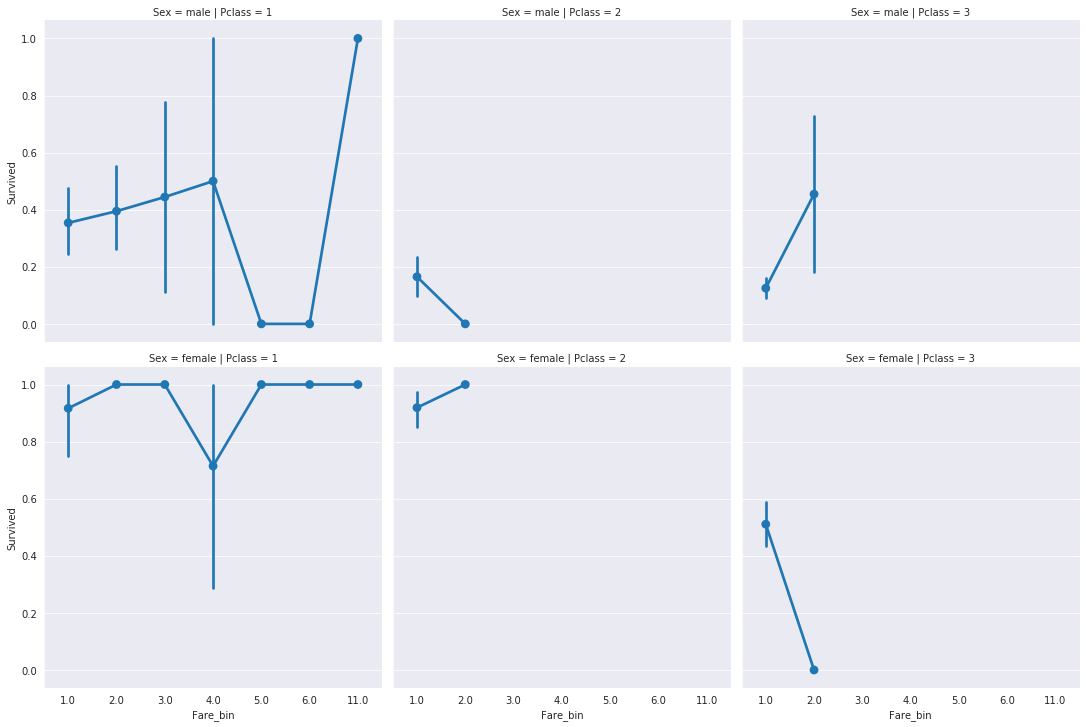

In [27]:
sns.catplot('Fare_bin','Survived', col='Pclass' , row = 'Sex', kind='point', data=df_train);

### 2.10.SibSp, Parch と生存率

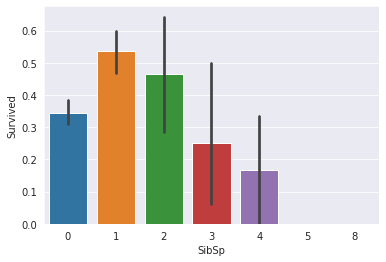

In [28]:
sns.barplot(x='SibSp',y='Survived',data=df_train)

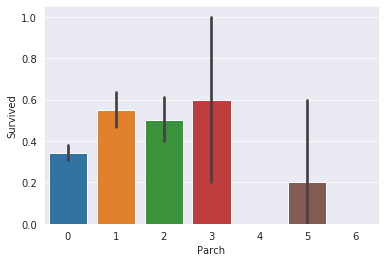

In [29]:
sns.barplot(x='Parch',y='Survived',data=df_train)

## 3. モデルの作成

### 3.1. ダミー変数の作成

カテゴリデータをダミー変数化する。

In [30]:
# データをコピー
df_train_ml = df_train.copy()
df_test_ml = df_test.copy()

In [31]:
df_train_ml = pd.get_dummies(df_train_ml, columns=['Sex', 'Embarked', 'Pclass'], drop_first=True)
df_train_ml.drop(['PassengerId','Name','Ticket', 'Cabin', 'Age_bin', 'Fare_bin', 'Fare'], axis=1,inplace=True)
df_train_ml.dropna(inplace=True)

passenger_id = df_test_ml['PassengerId']
df_test_ml = pd.get_dummies(df_test_ml, columns=['Sex', 'Embarked', 'Pclass'], drop_first=True)
df_test_ml.drop(['PassengerId','Name','Ticket', 'Cabin', 'Age_bin', 'Fare_bin', 'Fare'], axis=1,inplace=True)

In [32]:
df_train_ml

,Survived,Age,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,22.0,1,0,1,0,1,0,1
1,1,38.0,1,0,0,0,0,0,0
2,1,26.0,0,0,0,0,1,0,1
3,1,35.0,1,0,0,0,1,0,0
4,0,35.0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...
885,0,39.0,0,5,0,1,0,0,1
886,0,27.0,0,0,1,0,1,1,0
887,1,19.0,0,0,0,0,1,0,0
889,1,26.0,0,0,1,0,0,0,0


### 3.2. 相関係数の算出

各変数の関係性を把握するために相関係数を算出する。

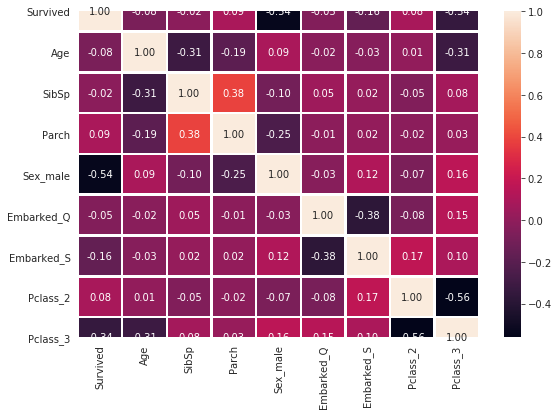

In [33]:
corr = df_train_ml.corr()

f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

### 3.3. 学習データとテストデータの分割

機械学習を行うために、データを学習用とテスト用に分割する。

In [34]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# for df_train_ml
scaler.fit(df_train_ml.drop('Survived',axis=1))
scaled_features = scaler.transform(df_train_ml.drop('Survived',axis=1))
df_train_ml_sc = pd.DataFrame(scaled_features, columns=df_train_ml.columns[:-1])

# for df_test_ml
df_test_ml.fillna(df_test_ml.mean(), inplace=True)
scaled_features = scaler.transform(df_test_ml)
df_test_ml_sc = pd.DataFrame(scaled_features, columns=df_test_ml.columns)

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train_ml.drop('Survived',axis=1), df_train_ml['Survived'], test_size=0.30, random_state=101)
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(df_train_ml_sc, df_train_ml['Survived'], test_size=0.30, random_state=101)

In [36]:
# unscaled
X_train_all = df_train_ml.drop('Survived',axis=1)
y_train_all = df_train_ml['Survived']
X_test_all = df_test_ml

### 3.4. モデルの作成と評価
#### 3.4.1. Logistic Regression

まずは Logistic 回帰モデルを作成する。

In [37]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
pred_logreg = logreg.predict(X_test)
pred_prob_logreg = logreg.predict_proba(X_test_sc)[:, 1]
print(confusion_matrix(y_test, pred_logreg))
print(classification_report(y_test, pred_logreg))
print(accuracy_score(y_test, pred_logreg))

[[109  14]
 [ 30  62]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       123
           1       0.82      0.67      0.74        92

    accuracy                           0.80       215
   macro avg       0.80      0.78      0.79       215
weighted avg       0.80      0.80      0.79       215

0.7953488372093023


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


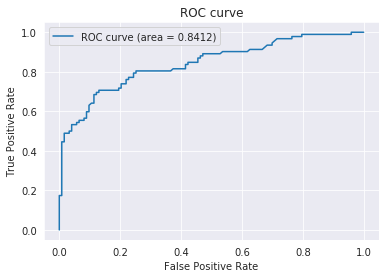

In [38]:
fpr_logreg, tpr_logreg, thresholds_logreg = metrics.roc_curve(y_test_sc, pred_prob_logreg)
auc_logreg = metrics.auc(fpr_logreg, tpr_logreg)
# ROC曲線をプロット
plt.plot(fpr_logreg, tpr_logreg, label='ROC curve (area = %.4f)'%auc_logreg)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

#### 3.4.2. RandomForest

次に RnadomForest のモデル作成・評価を行う。

In [39]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=7, max_features=5, random_state=1234)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)
pred_prob_rfc = rfc.predict_proba(X_test_sc)[:, 1]
print(confusion_matrix(y_test, pred_rfc))
print(classification_report(y_test, pred_rfc))
print(accuracy_score(y_test, pred_rfc))

[[114   9]
 [ 33  59]]
              precision    recall  f1-score   support

           0       0.78      0.93      0.84       123
           1       0.87      0.64      0.74        92

    accuracy                           0.80       215
   macro avg       0.82      0.78      0.79       215
weighted avg       0.81      0.80      0.80       215

0.8046511627906977


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


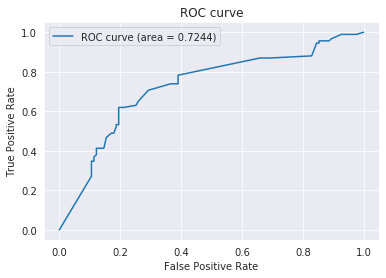

In [40]:
fpr_rfc, tpr_rfc, thresholds_rfc = metrics.roc_curve(y_test_sc, pred_prob_rfc)
auc_rfc = metrics.auc(fpr_rfc, tpr_rfc)
# ROC曲線をプロット
plt.plot(fpr_rfc, tpr_rfc, label='ROC curve (area = %.4f)'%auc_rfc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

#### 3.4.3. SVM

最後に SVM でのモデル作成・評価を行う。

In [41]:
from sklearn.svm import SVC
svc = SVC(gamma = 0.01, C = 100, probability=True, random_state=1234)
svc.fit(X_train_sc, y_train_sc)
pred_svc = svc.predict(X_test_sc)
pred_prob_svc = svc.predict_proba(X_test_sc)[:, 1]
print(confusion_matrix(y_test_sc, pred_svc))
print(classification_report(y_test_sc, pred_svc))
print(accuracy_score(y_test_sc, pred_svc))

[[116   7]
 [ 36  56]]
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       123
           1       0.89      0.61      0.72        92

    accuracy                           0.80       215
   macro avg       0.83      0.78      0.78       215
weighted avg       0.82      0.80      0.79       215

0.8


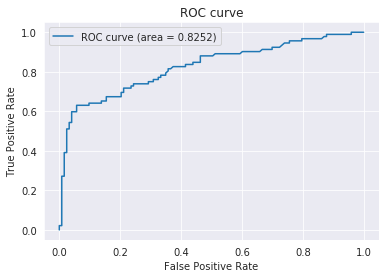

In [42]:
fpr_svc, tpr_svc, thresholds_svc = metrics.roc_curve(y_test_sc, pred_prob_svc)
auc_svc = metrics.auc(fpr_svc, tpr_svc)
# ROC曲線をプロット
plt.plot(fpr_svc, tpr_svc, label='ROC curve (area = %.4f)'%auc_svc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

## 4. [特徴量エンジニアリング](https://yolo-kiyoshi.com/2020/01/22/post-1588/)

モデルの精度を高めるために特徴量エンジニアリングを行っていく。  
まずはデータをコーピーする。

In [43]:
df_train_fe = df_train.copy()
df_test_fe = df_test.copy()

df_train_fe['train_or_test'] = 'train'
df_test_fe['train_or_test'] = 'test'

alldata = pd.concat([df_train_fe,df_test_fe],sort=False,axis=0).reset_index(drop=True)

### 4.1. Family Size

SibSp（兄弟・配偶者の人数） と Parch（親や子供の人数） から、家族人数を作成。  
さらにそれを big, mediam, small, alone のクラスに分ける。

In [44]:
# Familysize を作成
alldata['FamilySize'] = alldata['Parch'] + alldata['SibSp'] + 1 #ALLデータ
# FamilySize を離散化
alldata['FamilySize_bin'] = 'big'
alldata.loc[alldata['FamilySize']==1,'FamilySize_bin'] = 'alone'
alldata.loc[(alldata['FamilySize']>=2) & (alldata['FamilySize']<=4),'FamilySize_bin'] = 'small'
alldata.loc[(alldata['FamilySize']>=5) & (alldata['FamilySize']<=7),'FamilySize_bin'] = 'mediam'

### 4.2. Ticket

同じチケットを持っている人数を特徴量とする。

In [45]:
for df in [df_train_fe, df_test_fe]:
    df.loc[:, 'TicketFreq'] = df.groupby(['Ticket'])['PassengerId'].transform('count')

また、Ticketの戦闘文字でクラスに分ける。また文字列の長さも特徴量とする。

In [46]:
for df in [df_train_fe, df_test_fe]:
    df['Ticket_Lett'] = df['Ticket'].apply(lambda x: str(x)[0])
    df['Ticket_Lett'] = df['Ticket_Lett'].apply(lambda x: str(x)) 
    df['Ticket_Lett'] = np.where((df['Ticket_Lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), df['Ticket_Lett'], np.where((df['Ticket_Lett']).isin(['W', '4', '7', '6', 'L', '5', '8']), '0','0')) 
    df['Ticket_Len'] = df['Ticket'].apply(lambda x: len(x)) 
    df['Ticket_Lett'] = df['Ticket_Lett'].replace("1",1).replace("2",2).replace("3",3).replace("0",0).replace("S",3).replace("P",0).replace("C",3).replace("A",3)

### 4.3. Name

Name に存在している敬称を変数にする。  
出現度の低い敬称は Rare に統合する。

In [47]:
# テストデータの敬称を抽出
alldata['honorific'] = alldata['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
# 敬称の加工
alldata['honorific'].replace(['Col','Dr', 'Rev'], 'Rare',inplace=True) #少数派の敬称を統合
alldata['honorific'].replace('Mlle', 'Miss',inplace=True) #Missに統合
alldata['honorific'].replace('Ms', 'Miss',inplace=True) #Missに統合

### 4.4. Fare

旅客運賃はいくつかの外れ値があるのでビニングする。

In [48]:
# Fareの分割
alldata.loc[:, 'Fare_bin'] = pd.qcut(alldata.Fare, 14)
alldata.Fare_bin = alldata.Fare_bin.astype('str')

### 4.5. Cabin

客室番号の頭文字を変数とする。

In [49]:
# Cabinの頭文字
alldata['Cabin_ini'] = alldata['Cabin'].map(lambda x:str(x)[0])
alldata['Cabin_ini'].replace(['G','T'], 'Rare',inplace=True) #少数派のCabin_iniを統合

### 4.6. Pclass を文字列に変化

旅客クラスが整数型になっているので、整数型に変換する。

In [50]:
# PclassをObject型に変換
alldata.Pclass = alldata.Pclass.astype('str')

### 4.7. カテゴリ変数の変換

一部数値化できるカテゴリ変数を数値に変換する。

- Sex: O or 1
- Fare_bin: 瓶の順番を数値にする

In [51]:
# カテゴリ特徴量についてlabel encoding
from sklearn.preprocessing import LabelEncoder
le_target_col = ['Sex', 'Fare_bin']
le = LabelEncoder()
for col in le_target_col:
    alldata.loc[:, col] = le.fit_transform(alldata[col])

次に他のカテゴリ変数をダミー変数化する。

In [52]:
# カテゴリカル変数
cat_col = ['Pclass', 'Embarked','honorific','Cabin_ini', 'FamilySize_bin', 'Fare_bin']
alldata = pd.get_dummies(alldata, drop_first=True, columns=cat_col)

最終的なデータを確認する。

In [53]:
alldata

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Fare_bin_5,Fare_bin_6,Fare_bin_7,Fare_bin_8,Fare_bin_9,Fare_bin_10,Fare_bin_11,Fare_bin_12,Fare_bin_13,Fare_bin_14
0,1,0.0,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,...,0,0,0,1,0,0,0,0,0,0
1,2,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,...,0,0,1,0,0,0,0,0,0,0
2,3,1.0,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,0,0,0,0,0,1,0,0,0,0
3,4,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,...,0,1,0,0,0,0,0,0,0,0
4,5,0.0,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,"Spector, Mr. Woolf",1,NaN,0,0,A.5. 3236,8.0500,NaN,...,0,0,0,0,0,1,0,0,0,0
1305,1306,NaN,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,C105,...,0,0,0,0,0,0,0,0,1,0
1306,1307,NaN,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,...,0,0,0,1,0,0,0,0,0,0
1307,1308,NaN,"Ware, Mr. Frederick",1,NaN,0,0,359309,8.0500,NaN,...,0,0,0,0,0,1,0,0,0,0


## 5. 改良版モデルの作成

### 5.1. データの作成

機械学習させるためにデータを変形させる。

In [54]:
# 最初に統合したtrainとtestを分離
df_train_fe = alldata.query('train_or_test == "train"')
df_test_fe = alldata.query('train_or_test == "test"')
# ターゲット変数と、学習に不要なカラムを定義
target_col = 'Survived'
drop_col = ['PassengerId','Survived', 'Name', 'Fare', 'Age_bin', 'Ticket', 'Cabin', 'train_or_test', 'Age', 'Parch', 'FamilySize', 'SibSp']
# 学習に必要な特徴量のみを保持
train_feature = df_train_fe.drop(columns=drop_col)
test_feature = df_test_fe.drop(columns=drop_col)
train_tagert = df_train_fe[target_col]
# trainデータを分割
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    train_feature, train_tagert, test_size=0.2, random_state=101, stratify=train_tagert)

変数を確認する。

In [55]:
df_train_fe.columns

Index(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Age_bin', 'train_or_test', 'FamilySize',
       'Pclass_2', 'Pclass_3', 'Embarked_Q', 'Embarked_S', 'honorific_Don',
       'honorific_Dona', 'honorific_Jonkheer', 'honorific_Lady',
       'honorific_Major', 'honorific_Master', 'honorific_Miss',
       'honorific_Mme', 'honorific_Mr', 'honorific_Mrs', 'honorific_Rare',
       'honorific_Sir', 'honorific_the Countess', 'Cabin_ini_B', 'Cabin_ini_C',
       'Cabin_ini_D', 'Cabin_ini_E', 'Cabin_ini_F', 'Cabin_ini_Rare',
       'Cabin_ini_n', 'FamilySize_bin_big', 'FamilySize_bin_mediam',
       'FamilySize_bin_small', 'Fare_bin_1', 'Fare_bin_2', 'Fare_bin_3',
       'Fare_bin_4', 'Fare_bin_5', 'Fare_bin_6', 'Fare_bin_7', 'Fare_bin_8',
       'Fare_bin_9', 'Fare_bin_10', 'Fare_bin_11', 'Fare_bin_12',
       'Fare_bin_13', 'Fare_bin_14'],
      dtype='object')

In [56]:
X_train_fe

,Sex,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,honorific_Don,honorific_Dona,honorific_Jonkheer,honorific_Lady,honorific_Major,...,Fare_bin_5,Fare_bin_6,Fare_bin_7,Fare_bin_8,Fare_bin_9,Fare_bin_10,Fare_bin_11,Fare_bin_12,Fare_bin_13,Fare_bin_14
702,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
776,1,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
381,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
16,1,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
494,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
430,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 5.2. Logistic Regression

In [57]:
logreg_fe = LogisticRegression()
logreg_fe.fit(X_train_fe,y_train_fe)
pred_logreg_fe = logreg_fe.predict(X_test_fe)
pred_prob_logreg_fe = logreg_fe.predict_proba(X_test_fe)[:, 1]
print(confusion_matrix(y_test_fe, pred_logreg_fe))
print(classification_report(y_test_fe, pred_logreg_fe))
print(accuracy_score(y_test_fe, pred_logreg_fe))

[[102   8]
 [ 25  44]]
              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86       110
         1.0       0.85      0.64      0.73        69

    accuracy                           0.82       179
   macro avg       0.82      0.78      0.79       179
weighted avg       0.82      0.82      0.81       179

0.8156424581005587


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


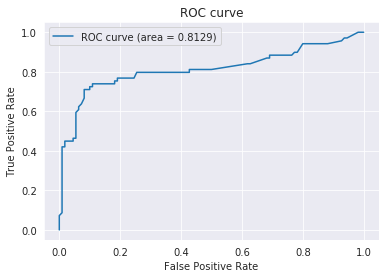

In [58]:
fpr_logreg_fe, tpr_logreg_fe, thresholds_logreg_fe = metrics.roc_curve(y_test_fe, pred_prob_logreg_fe)
auc_logreg_fe = metrics.auc(fpr_logreg_fe, tpr_logreg_fe)
# ROC曲線をプロット
plt.plot(fpr_logreg_fe, tpr_logreg_fe, label='ROC curve (area = %.4f)'%auc_logreg_fe)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### 5.3. RandomForest

In [59]:
rfc_fe = RandomForestClassifier(max_depth=20, max_features='auto', n_estimators=50, min_samples_split=20, min_samples_leaf=10, random_state=1234)
rfc_fe.fit(X_train_fe, y_train_fe)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

In [60]:
pred_rfc_fe = rfc_fe.predict(X_test_fe)
pred_prob_rfc_fe = rfc_fe.predict_proba(X_test_fe)[:, 1]
print(confusion_matrix(y_test_fe, pred_rfc_fe))
print(classification_report(y_test_fe, pred_rfc_fe))
print(accuracy_score(y_test_fe, pred_rfc_fe))

[[106   4]
 [ 26  43]]
              precision    recall  f1-score   support

         0.0       0.80      0.96      0.88       110
         1.0       0.91      0.62      0.74        69

    accuracy                           0.83       179
   macro avg       0.86      0.79      0.81       179
weighted avg       0.85      0.83      0.82       179

0.8324022346368715


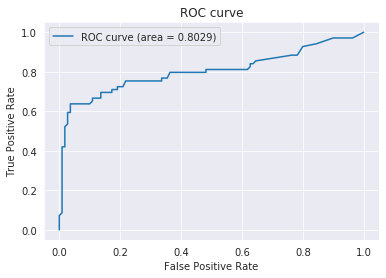

In [61]:
fpr_rfc_fe, tpr_rfc_fe, thresholds_rfc_fe = metrics.roc_curve(y_test_fe, pred_prob_rfc_fe)
auc_rfc_fe = metrics.auc(fpr_rfc_fe, tpr_rfc_fe)
# ROC曲線をプロット
plt.plot(fpr_rfc_fe, tpr_rfc_fe, label='ROC curve (area = %.4f)'%auc_rfc_fe)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### 5.4. SVM

In [62]:
svc_fe = SVC(gamma = 0.01, C = 200, probability=True)
svc_fe.fit(X_train_fe, y_train_fe)

SVC(C=200, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [63]:
pred_svc_fe = svc_fe.predict(X_test_fe)
pred_prob_svc_fe = svc_fe.predict_proba(X_test_fe)[:, 1]
print(confusion_matrix(y_test_fe, pred_svc_fe))
print(classification_report(y_test_fe, pred_svc_fe))
print(accuracy_score(y_test_fe, pred_svc_fe))

[[102   8]
 [ 25  44]]
              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86       110
         1.0       0.85      0.64      0.73        69

    accuracy                           0.82       179
   macro avg       0.82      0.78      0.79       179
weighted avg       0.82      0.82      0.81       179

0.8156424581005587


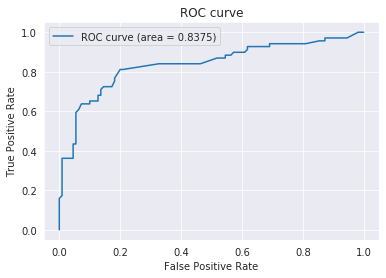

In [64]:
fpr_svc_fe, tpr_svc_fe, thresholds_svc_fe = metrics.roc_curve(y_test_fe, pred_prob_svc_fe)
auc_svc_fe = metrics.auc(fpr_svc_fe, tpr_svc_fe)
# ROC曲線をプロット
plt.plot(fpr_svc_fe, tpr_svc_fe, label='ROC curve (area = %.4f)'%auc_svc_fe)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### 5.5. 特徴量を追加した前後での ROC の比較

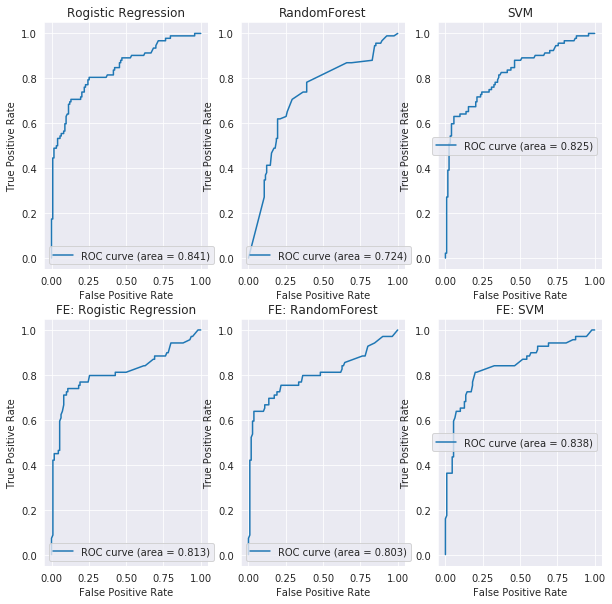

In [65]:
import matplotlib.gridspec as gridspec
from pylab import rcParams
rcParams['figure.figsize'] = 10,10
gs = gridspec.GridSpec(2,3)

ax11 = plt.subplot(gs[0,0])
ax12 = plt.subplot(gs[0,1])
ax13 = plt.subplot(gs[0,2])
ax21 = plt.subplot(gs[1,0])
ax22 = plt.subplot(gs[1,1])
ax23 = plt.subplot(gs[1,2])

ax11.plot(fpr_logreg, tpr_logreg, label='ROC curve (area = %.3f)'%auc_logreg)
ax11.legend()
ax11.set_title('Rogistic Regression')
ax11.set_xlabel('False Positive Rate')
ax11.set_ylabel('True Positive Rate')
ax11.grid(True)

ax12.plot(fpr_rfc, tpr_rfc, label='ROC curve (area = %.3f)'%auc_rfc)
ax12.legend()
ax12.set_title('RandomForest')
ax12.set_xlabel('False Positive Rate')
ax12.set_ylabel('True Positive Rate')
ax12.grid(True)

ax13.plot(fpr_svc, tpr_svc, label='ROC curve (area = %.3f)'%auc_svc)
ax13.legend()
ax13.set_title('SVM')
ax13.set_xlabel('False Positive Rate')
ax13.set_ylabel('True Positive Rate')
ax13.grid(True)

ax21.plot(fpr_logreg_fe, tpr_logreg_fe, label='ROC curve (area = %.3f)'%auc_logreg_fe)
ax21.legend()
ax21.set_title('FE: Rogistic Regression')
ax21.set_xlabel('False Positive Rate')
ax21.set_ylabel('True Positive Rate')
ax21.grid(True)

ax22.plot(fpr_rfc_fe, tpr_rfc_fe, label='ROC curve (area = %.3f)'%auc_rfc_fe)
ax22.legend()
ax22.set_title('FE: RandomForest')
ax22.set_xlabel('False Positive Rate')
ax22.set_ylabel('True Positive Rate')
ax22.grid(True)

ax23.plot(fpr_svc_fe, tpr_svc_fe, label='ROC curve (area = %.3f)'%auc_svc_fe)
ax23.legend()
ax23.set_title('FE: SVM')
ax23.set_xlabel('False Positive Rate')
ax23.set_ylabel('True Positive Rate')
ax23.grid(True)